In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import pandas.tseries.offsets as offsets
import random
import os
import arff
import time
from sklearn.metrics import r2_score
from statsmodels.tools.eval_measures import rmse
import torch # entire library
import torch.nn as nn # all neural network moduals, e.g., linear, convolutional, loss function
import torch.optim as optim # optimization function
import torch.nn.functional as F # all functions that do not have parameters, e.g., Relu, Tanh, etc
from torch.utils.data import TensorDataset, DataLoader # easier data management
import torchvision.datasets as datasets # standard datasets
from torch.utils.data import Dataset
import torchvision.transforms as transforms # transformations on datasets
from torch.optim.lr_scheduler import ExponentialLR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

In [2]:
def mae(y,yh):
    return np.mean(np.abs(y-yh))

In [3]:
def data_splition(df, id1, id2):
    train = df.iloc[:id1,:].astype('float32')
    valid = df.iloc[id1:id2,:].astype('float32')
    test  = df.iloc[id2:,:].astype('float32')
    return train, valid, test

In [4]:
def seq_preparation_y(x, y, len_seq):
    X, Y = np.zeros((x.shape[0]-len_seq, len_seq, x.shape[1])), np.zeros((x.shape[0]-len_seq, 1))
    for i in range(len_seq, len(x)):
        X[i-len_seq, :, :] = (x.iloc[i-len_seq:i, :])
        Y[i-len_seq] = (y[i])
    return X, Y

In [5]:
def seed_worker(worker_seed):
    # worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    torch.manual_seed(worker_seed)

In [25]:
def data_loader_prep(X, y, batch_size, seed):
    X, y = torch.Tensor(X), torch.Tensor(y)
    data = TensorDataset(X, y)
    g = torch.Generator()
    data_loader = DataLoader(data, batch_size=batch_size, shuffle=False, drop_last=False, worker_init_fn=seed_worker(seed), generator=g)
    return data_loader


In [8]:
df_long = pd.read_excel("C:/Users\liuwe\Desktop\Daily\Research\ENEOS\Data_3/New_LSR/211213_根岸LSR平衡還流沸点データ.xlsx",
                     sheet_name='DataBase(432)', header=3, index_col=0, skiprows=range(4,5))
df_short= pd.read_excel("C:/Users\liuwe\Desktop\Daily\Research\ENEOS\Data_3/New_LSR/211213_根岸LSR平衡還流沸点データ.xlsx",
                     sheet_name='DataBase(122)', header=3, index_col=0, skiprows=range(4,5))

In [7]:
def read_data(df_long, df_short, seq_len, seed):
    df_data = pd.concat([df_long.iloc[:315,:], df_short])
    df_date = df_data.pop('Date')
    data_tr, data_vl, data_te = data_splition(df_data, 300, 337)
    # scaler = StandardScaler()
    scaler = MinMaxScaler()
    data_tr.iloc[:, 1:] = scaler.fit_transform(data_tr.iloc[:,1:])
    data_vl.iloc[:, 1:] = scaler.transform(data_vl.iloc[:,1:])
    data_te.iloc[:, 1:] = scaler.transform(data_te.iloc[:,1:])

    X_tr, y_tr = seq_preparation(data_tr, seq_len)
    X_vl, y_vl = seq_preparation(data_vl, seq_len)
    X_te, y_te = seq_preparation(data_te, seq_len)
    train_loader = data_loader_prep(X_tr, y_tr, batch_size=30, seed=seed) #3-37 #5-29 #10-29 
    valid_loader = data_loader_prep(X_vl, y_vl, batch_size=3, seed=seed) #3-3   #5-4  #10-3  
    test_loader = data_loader_prep(X_te, y_te, batch_size=10, seed=seed) #3-12  #5-10 #10-9   
    return train_loader, valid_loader, test_loader, y_tr, y_vl, y_te, df_date

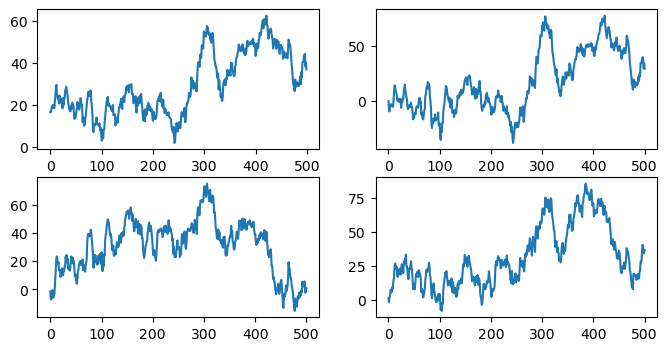

In [82]:
T = 500 # Time steps
n = 50 # Initial dimension
d = 3 # Dimension after transformation

# Transition matrix
A = np.diag([1]*d)
# B = scipy.sparse.csc_matrix((d, n), dtype=None)
seed = 6
np.random.seed(seed)
B = np.random.rand(d, n)
cov = np.array([[0.0351,0.0017,0],[0,0.0289,0.0002],[0.0004,0,0.0298]])
w_t = np.random.multivariate_normal([0, 0, 0], cov @ cov.transpose(), size=T)
v_t = np.random.normal(0, 1, size = T)
theta = np.array([0.45,-0.1,0.15])
z_t = np.zeros((T+1,d))
z_t[0,:] = np.random.normal(size=d)
x_t, y = make_regression(n_samples=T, n_features=n, n_informative=d, noise=0, random_state=42)
y_t = np.zeros(T)
for t in range(T):
    z_t[t+1,:] = A @ z_t[t,:] + B @ x_t[t,:] + w_t[t,:]
    y_t[t] = theta @ z_t[t+1,:] + 20 + v_t[t]

plt.rcParams['figure.figsize'] = (8,4)
fig, axes = plt.subplots(2,2)
axes[0,0].plot(y_t)
axes[0,1].plot(z_t[:,0])
axes[1,0].plot(z_t[:,1])
axes[1,1].plot(z_t[:,2])

In [7]:
def read_data(X, y, seq_len, seed, index1, index2):
    df_data = pd.DataFrame(X)
    df_data.insert(0,'Target', y)
    data_tr, data_vl, data_te = data_splition(df_data, index1, index2)
    X_tr, y_tr = seq_preparation_y(data_tr, y[:index1], seq_len)
    X_vl, y_vl = seq_preparation_y(data_vl, y[index1:index2], seq_len)
    X_te, y_te = seq_preparation_y(data_te, y[index2:], seq_len)
    train_loader = data_loader_prep(X_tr, y_tr, batch_size=50, seed=seed) 
    valid_loader = data_loader_prep(X_vl, y_vl, batch_size=20, seed=seed) 
    test_loader = data_loader_prep(X_te, y_te, batch_size=50, seed=seed)
    return train_loader, valid_loader, test_loader, y_tr, y_vl, y_te

Text(0.5, 1.0, 'Data splition when using NNs')

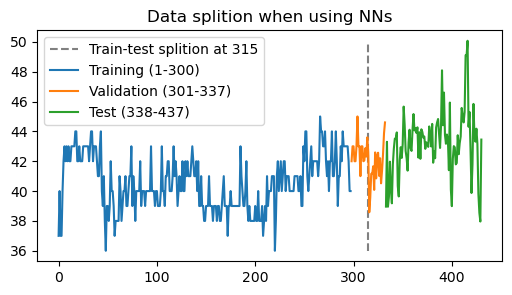

In [138]:
plt.rcParams["figure.figsize"] = (6,3)
plt.vlines(x = 315, ymin = 36, ymax = 50, ls='--', colors='grey', label='Train-test splition at 315')
plt.plot(np.arange(len(y_tr)), y_tr, label='Training (1-300)')
plt.plot(np.arange(len(y_tr),len(y_tr) + len(y_vl)), y_vl, label='Validation (301-337)')
plt.plot(np.arange(len(y_tr) + len(y_vl), len(y_tr) + len(y_vl)+len(y_te)), y_te, label='Test (338-437)')
plt.legend()
plt.title('Data splition when using NNs')

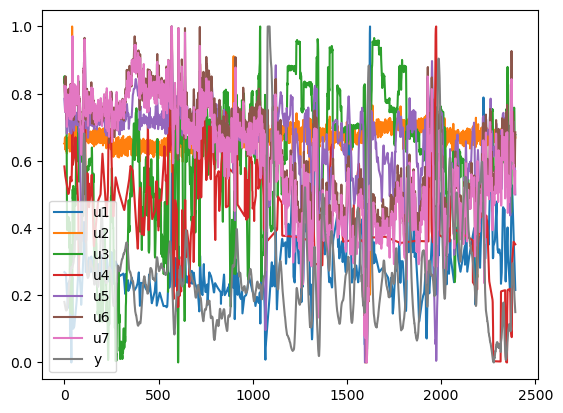

In [8]:
# Debutanizer Column data set
df = pd.read_csv('C:/Users\liuwe\Desktop\Daily\Research\Dataset\Debutanizer Column\debutanizer_data.txt', 
                 delimiter='\s+', header=None, skiprows=3, names=['u1','u2','u3','u4','u5','u6','u7','y'],)
df.plot() # already normalized data
y_column = df.pop('y').values
X_column = df.values

In [197]:
# Melt index prediction
MI1 = pd.read_csv('C:/Users\liuwe\Desktop\Daily\Research\Dataset\Melt Index\M1.txt',header=0,index_col=0,sep='\t')
MI2 = pd.read_csv('C:/Users\liuwe\Desktop\Daily\Research\Dataset\Melt Index\M2.txt',header=0,sep='\t')
MI3 = pd.read_csv('C:/Users\liuwe\Desktop\Daily\Research\Dataset\Melt Index\M3.txt',header=0,sep='\t')
MI1 = MI1.reset_index(drop=True)
raw_data = pd.concat([MI2.iloc[:,:8], MI3], axis=1)
raw_data.drop(314, inplace=True)
target = raw_data.pop(raw_data.columns[-1]).values
# Already in the range of 0~1 and include a constant column

In [31]:
# Gas Turbine CO and NOx emission data set
# 2012 len = 7628
df_gas = pd.read_csv('C:/Users\liuwe\Desktop\Daily\Research\Dataset\Gas Turbine CO and NOx Emission Data Set\gt_2012.csv')
# resample_fre = round(df_gas.shape[0]/365)
# df_gas_day = df_gas[::20].iloc[:365,:].reset_index(drop=True)
y_NO = df_gas.pop('NOX').values
y_CO = df_gas.pop('CO').values
X_gas = df_gas.values
X_gas = StandardScaler().fit_transform(X_gas)

In [3]:
# Sulfur recovery unit dataset
dataset = arff.load(open('C:/Users\liuwe\Desktop\Daily\Research\Dataset\Sulfur Recovery Unit\Sulfur.arff'))
data = pd.DataFrame(dataset['data'])
features, target  = data.iloc[:, :5], data.iloc[:, 5:]
features_lagged = pd.concat([features, 
                             features.shift(5),
                             features.shift(7),
                             features.shift(9)], axis=1)
features_lagged, target = features_lagged.iloc[9:,:], target.iloc[9:,:]
X_sulfur, y_sulfur = features_lagged.values, target.iloc[:,1].values

Text(0.5, 1.0, 'Observations of SO2 concentration')

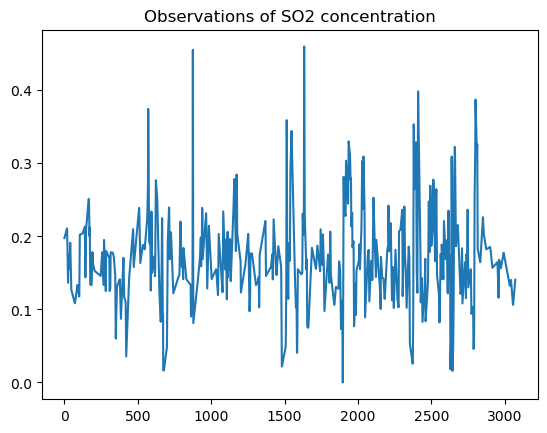

In [6]:
plt.plot(y_sulfur[7000:])
plt.title('Observations of SO2 concentration')

In [9]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers): 
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) # , nonlinearity='relu'
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):                                                                               
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)
        out = out[:, -1, :]
        out = self.fc(out)
        return out                                                                                                    

In [10]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers): 
        super(LSTMModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):            
        batch_size = x.size(0)                                                                  
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.fc(hn[0])#.flatten()
        return out    

In [275]:
def Model_train(epoch_num = 10, hidden_size=None, num_layers=None, lr=None):
    model = LSTMModel(input_size=21, hidden_size=hidden_size, num_layers=num_layers)
    criterion = nn.MSELoss() 
    optimizer = optim.SGD(model.parameters(), lr=lr)
    # data_result = read_data(raw_data.values, target, seq_len=3, seed=0, index1=200, index2=249)
    data_result = read_data(X_sulfur, y_sulfur, seq_len=3, seed=0, index1=5000, index2=7000)
    # data_result = read_data(df_long, df_short, seq_len=3, seed=0)
    # data_result = read_data(X_gas, y_CO, seq_len=3, seed=0, index1=250, index2=300)
    # data_result = read_data(X_column, y_column, seq_len=5, seed=0, index1=1600, index2=2000)

    train_loader, valid_loader = data_result[0], data_result[1]

    training_loss, validation_loss = [], []

    for epoch in range(epoch_num):

        # model training
        model.train()
        batch_losses = 0
        for X_batch, y_batch in train_loader:                                          
            ytrhat = model(X_batch)
            loss = criterion(ytrhat, y_batch)
            batch_losses += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        training_loss.append(batch_losses)

        # model evaluation
        model.eval()
        batch_val_losses = 0
        with torch.no_grad():
            for x_val, y_val in valid_loader:
                yvlhat = model(x_val)
                val_loss = criterion(yvlhat, y_val)
                batch_val_losses += val_loss.item()
            validation_loss.append(batch_val_losses)
        
        
        if (epoch <= 10) | (epoch % 100 == 0):
                print(
                    f"{epoch}/{epoch_num} Training loss: {np.sqrt(batch_losses):.4f} Validation loss: {np.sqrt(batch_val_losses):.4f}"
                )


    return model, training_loss, validation_loss


In [12]:
def Model_eval(model, data_loader = None):
    model.eval()
    predictions = []
    with torch.no_grad():
        for x_val, y_val in data_loader:
            ytehat = model(x_val)
            predictions = np.append(predictions, ytehat.detach().numpy().squeeze())

    return np.asarray(predictions)

In [172]:
def Model_offline_eval(model, X, y, seq_len, seed, index2):
    model.eval()
    predictions = []
    test = np.concatenate((X, y.reshape((-1,1))),axis=1)
    test = test[np.newaxis,index2:,:].astype('float32')
    y_te = y[index2:].astype('float32')
    for i in range(seq_len,test.shape[1]):
        test_loader = data_loader_prep(np.array(test[:,i-seq_len:i,:]), np.array(y_te[i].reshape((1,1))), batch_size=1, seed=seed)
        with torch.no_grad():
            for x_loader, y_loader in test_loader:
                ytehat = model(x_loader)  
                predict = ytehat.detach().numpy().squeeze()
                test[:,i,-1] = predict
                predictions = np.append(predictions, predict)
    return np.asarray(predictions)

In [276]:
num_layers = 2
hidden_size = 100
learning_rate = 0.0001
num_epochs = 250
# train_loader, valid_loader, test_loader, y_tr, y_vl, y_te = read_data(raw_data.values, target, seq_len=3, seed=0, index1=200, index2=249)
# train_loader, valid_loader, test_loader, y_tr, y_vl, y_te, date = read_data(df_long, df_short, seq_len=3, seed=0)
# train_loader, valid_loader, test_loader, y_tr, y_vl, y_te = read_data(X_gas, y_CO, seq_len=3, seed=0, index1=5000, index2=7000)
train_loader, valid_loader, test_loader, y_tr, y_vl, y_te = read_data(X_sulfur, y_sulfur, seq_len=3, seed=0, index1=5000, index2=7000)
# train_loader, valid_loader, test_loader, y_tr, y_vl, y_te = read_data(X_column, y_column, seq_len=5, seed=0, index1=1600, index2=2000)

start_time = time.time()                 
model, train_loss, valid_loss = Model_train(epoch_num=num_epochs, hidden_size=hidden_size, num_layers=num_layers, lr=learning_rate)
end_time = time.time()
print("Running time : %.4f" % (end_time-start_time))

ytrhat = Model_eval(model=model, data_loader=train_loader)
yvlhat = Model_eval(model=model, data_loader=valid_loader)
ytehat = Model_eval(model=model, data_loader=test_loader)

print(f'Train RMSE: {np.sqrt(mean_squared_error(ytrhat, y_tr)):.4f}')
print(f'Valid RMSE: {np.sqrt(mean_squared_error(yvlhat, y_vl)):.4f}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(ytehat, y_te)):.4f}')

0/250 Training loss: 2.6748 Validation loss: 2.7046
1/250 Training loss: 2.5740 Validation loss: 2.5973
2/250 Training loss: 2.4774 Validation loss: 2.4945
3/250 Training loss: 2.3850 Validation loss: 2.3959
4/250 Training loss: 2.2966 Validation loss: 2.3015
5/250 Training loss: 2.2119 Validation loss: 2.2110
6/250 Training loss: 2.1309 Validation loss: 2.1243
7/250 Training loss: 2.0534 Validation loss: 2.0412
8/250 Training loss: 1.9792 Validation loss: 1.9617
9/250 Training loss: 1.9082 Validation loss: 1.8854
10/250 Training loss: 1.8404 Validation loss: 1.8124
100/250 Training loss: 0.6103 Validation loss: 0.4699
200/250 Training loss: 0.6073 Validation loss: 0.4756
Running time : 229.5346
Train RMSE: 0.0607
Valid RMSE: 0.0475
Test RMSE: 0.0543


In [277]:
# ytehat_off = Model_offline_eval(model=model,X=X_column,y=y_column,seq_len=5,seed=0,index2=2000)
# ytehat_off = Model_offline_eval(model=model,X=raw_data.values,y=target,seq_len=3,seed=0,index2=249)
ytehat_off = Model_offline_eval(model=model,X=X_sulfur,y=y_sulfur,seq_len=3,seed=0,index2=7000)

print(f'Test RMSE: {np.sqrt(mean_squared_error(ytehat_off, y_te)):.4f}')

Test RMSE: 0.0547


In [278]:
print('train rmse %.4f, mae %.4f ' % (rmse(y_tr.ravel(), ytrhat),mae(y_tr.ravel(), ytrhat)))
print('test on rmse %.4f, mae %.4f' % (rmse(y_te.ravel(), ytehat),mae(y_te.ravel(), ytehat)))
print('test off rmse %.4f, mae %.4f' % (rmse(y_te.ravel(), ytehat_off),mae(y_te.ravel(), ytehat_off)))

train rmse 0.0607, mae 0.0372 
test on rmse 0.0543, mae 0.0394
test off rmse 0.0547, mae 0.0400


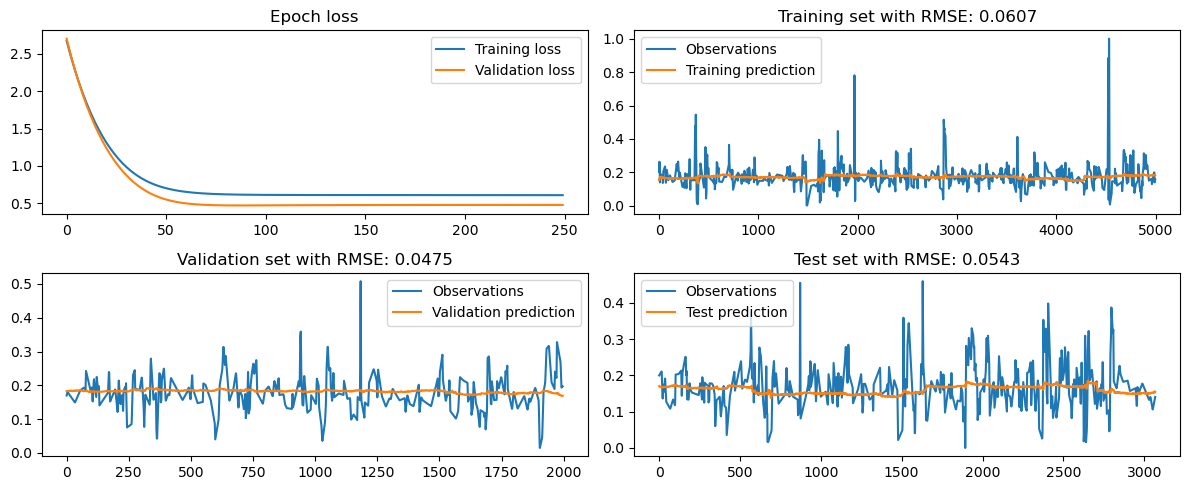

In [279]:
fig, axes = plt.subplots(2, 2, figsize=(12,5))

axes[0,0].plot(np.sqrt(train_loss), label='Training loss')
axes[0,0].plot(np.sqrt(valid_loss), label='Validation loss')
axes[0,0].set_title('Epoch loss')
axes[0,0].legend()

axes[0,1].plot(y_tr, label='Observations')
axes[0,1].plot(ytrhat, label='Training prediction')
axes[0,1].set_title(f'Training set with RMSE: {np.sqrt(mean_squared_error(ytrhat, y_tr)):.4f}')
axes[0,1].legend()

axes[1,0].plot(y_vl, label='Observations')
axes[1,0].plot(yvlhat, label='Validation prediction')
axes[1,0].set_title(f'Validation set with RMSE: {np.sqrt(mean_squared_error(yvlhat, y_vl)):.4f}')
axes[1,0].legend()

axes[1,1].plot(y_te, label='Observations')
axes[1,1].plot(ytehat, label='Test prediction')
axes[1,1].set_title(f'Test set with RMSE: {np.sqrt(mean_squared_error(ytehat, y_te)):.4f}')
axes[1,1].legend()

fig.tight_layout()
# fig, axes = plt.subplots( figsize=(10,3))
# axes.set_title(f'RNN RMSE: {np.sqrt(mean_squared_error(ytehat, y_te)):.4f}')
# axes.plot(ytehat, label='Predictions')
# axes.plot(y_te, label='Ground truth')
# axes.set_xticks(np.arange(19)*5, test_date, rotation='45')
# axes.legend()

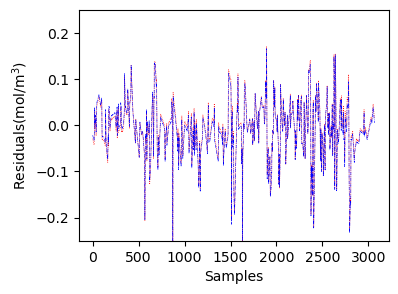

In [281]:
fig, axes = plt.subplots(figsize=(4,3))
# axes.plot(y_te, 'k-', linewidth=1, label='Measurements')
# -y_te.ravel()
axes.plot(ytehat-y_te.ravel(), 'r:', linewidth=0.5, label='Online prediction')
axes.plot(ytehat_off-y_te.ravel(), 'b-.', linewidth=0.4, label='Offline prediction')
# axes.set_ylabel('Butane content (%)')
# axes.set_ylabel('Melt index (g/10 min)')
axes.set_ylabel(r'Residuals(mol/m$^3$)')
axes.set_xlabel('Samples')
# axes.set_ylim(-0.2,0.8)
# axes.set_ylim(-0.03,0.28)
axes.set_ylim(-0.25,0.25)
# axes.legend()
relative_path = os.path.join('C:/Users\liuwe\Desktop\Daily\Research\ENEOS\Data_3/New_LSR\Experiment\KalmanFilter', 'Figures', 'SulfurLSTM.png')
plt.savefig(relative_path, dpi=600, bbox_inches='tight')

In [ ]:
y_te.ravel()

array([0.20134 , 0.20207 , 0.202799, ..., 0.136196, 0.138443, 0.14069 ])

In [ ]:
# learning_rate = 0.1
num_epochs = 500
# epoch_list = [50, 100, 200, 500, 1000, 1500, 2000]
lr_list = [0.00001, 0.0001, 0.001, 0.003, 0.005]
df_error = pd.DataFrame()
valid_error = pd.DataFrame()
for learning_rate in range(5):
    # for num_epochs in epoch_list:
    # for learning_rate in range(5):
    learning_rate = 10**(learning_rate-5)
    model = RNN(lr=learning_rate,epoch_num=num_epochs)
    ytrhat = model(torch.from_numpy(X_tr).to(torch.float32).requires_grad_()).detach().numpy()
    yvlhat = model(torch.from_numpy(X_vl).to(torch.float32).requires_grad_()).detach().numpy()
    df_error.at[str(learning_rate), 'train_error'] = np.sqrt(mean_squared_error(ytrhat, y_tr))
    df_error.at[str(learning_rate), 'valid_error'] = np.sqrt(mean_squared_error(yvlhat, y_vl))

0 1677.7181396484375
100 1665.07470703125
200 1653.0118408203125
300 1641.0670166015625
400 1628.787841796875


RuntimeError: Expected hidden size (2, 34, 10), got [2, 297, 10]

<AxesSubplot:title={'center':'momentum'}, ylabel='RMSE'>

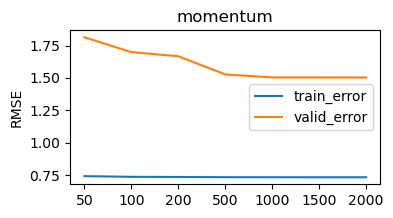

In [ ]:
df_error.plot( figsize=(4,2), title='momentum', ylabel='RMSE')

In [ ]:
model = OneFCLayer(lr=0.1,momentum=0.8,epoch_num=2000)
ytrhat = model(torch.from_numpy(data_tr).requires_grad_()).detach().numpy()
yvlhat = model(torch.from_numpy(data_vl).requires_grad_()).detach().numpy()
ytehat = model(torch.from_numpy(data_te).requires_grad_()).detach().numpy()
print(f'Training RMSE: {np.sqrt(mean_squared_error(ytrhat, y_train)):.4f}')
print(f'Validation RMSE: {np.sqrt(mean_squared_error(yvlhat, y_valid)):.4f}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(ytehat, y_test)):.4f}')

0 1636.7894287109375
100 0.5427432060241699
200 0.5396616458892822
300 0.5383985638618469
400 0.5377774834632874
500 0.5374333262443542
600 0.5372198820114136
700 0.5370727777481079
800 0.5369638800621033
900 0.5368793606758118
1000 0.5368093848228455
1100 0.536751389503479
1200 0.5367005467414856
1300 0.5366581082344055
1400 0.5366199016571045
1500 0.5365859270095825
1600 0.536557674407959
1700 0.5365301966667175
1800 0.5365064144134521
1900 0.5364839434623718
Training RMSE: 0.7324
Validation RMSE: 1.4970
Test RMSE: 1.6922


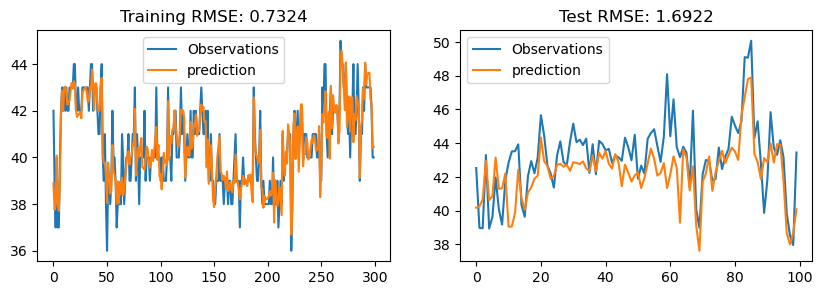

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(10,3))

ytrhat = model(torch.from_numpy(data_tr).requires_grad_()).detach().numpy()
axes[0].set_title(f'Training RMSE: {np.sqrt(mean_squared_error(ytrhat, y_train)):.4f}')
axes[0].plot(y_train, label='Observations')
axes[0].plot(ytrhat, label='prediction')
axes[0].legend()

ytehat = model(torch.from_numpy(data_te).requires_grad_()).detach().numpy()
axes[1].set_title(f'Test RMSE: {np.sqrt(mean_squared_error(ytehat, y_test)):.4f}')
axes[1].plot(y_test, label='Observations')
axes[1].plot(ytehat, label='prediction')

plt.legend()